# Dataset and Dataloaders

在机器学习中处理与读取数据是一件非常麻烦的事情，Pytorch对数据的读取做了统一的抽象，Pytorch中提供了2个基本的数据原语：`torch.utils.data.DataLoader`以及`torch.utils.data.Dataset`。

`Dataset` 负责实现如何获取数据集中的一条样本。`DataLoader`负责实现如何获取一个 Batch 的样本，包括如何控制 Shuffle 等。需要注意的是 `Dataset`在完成构造时，并不一定需要将数据真实的加载到内存中，很多情况下，初始化阶段只是加载了 meta 信息（比如存储路径等），真实的加载是在 `__getitem__`阶段。

既然我们可以直接通过下标来访问`Dataset`或通过迭代器来访问`Dataset`，为什么还要包装一个 `DataLoader`? `Dataloader` 主要在以下方面提供了功能增强。

1. 可以批量的加载数据
2. 支持在训练阶段随机打乱数据
3. 支持多进程数据加载
5. 支持异步的数据预取

另外 torchvision, torchtext, torchaudio 这三个库中还提供了一些派生于`torch.utils.data.Dataset`的用于加载公开测试集的类，它们搜集了一些经典的各类任务的数据集，提供了友好的读取数据集的实现，大部分数据集封装还提供了下载的功能。

我们可以用这些数据集来做为我们模型的benchmark测试。

- [Image Datasets](https://pytorch.org/vision/stable/datasets.html)
- [Text Datasets](https://pytorch.org/text/stable/datasets.html)
- [Audio Datasets](https://pytorch.org/audio/stable/datasets.html)




## Dataset

Dataset负责对 raw data source（Tensor、本地图片目录、csv数据、KV数据库等）进行封装，将其封装为Pytorch可识别的数据结构。它必须提供获取单个数据的接口`__getitem()__`。

Dataset 按读取数据的方式可以分为：map style dataset 和 iterable style dataset。

- map-style dataset：实现了`__getitem__`和`__len__`接口，表示一个从索引 key 到样本数据的映射，比如：`dataset[10]`就表示第10个样本。
- iterable style dataset: 实现了`__iter__`接口，表示在 data samples 上的一个可迭代的对象，这种形式的 dataset 不适合随机存取（代价太高），但非常适合处理流式数据。对于这样的数据集，我们可以通过`iter(dataset)`获取迭代器，然后不断使用`next`迭代，实现遍历。

所以说`Dataset`是可迭代对象，可以用`for xx in ds`这样的语法，但是不是迭代器，不可以直接通过`next`来获取元素。Python 规定：有 `__iter__()`接口的或者 `__getitem__()`接口的类对象是可迭代对象，有`__iter__()`接口和`__next__()`接口的类对象是迭代器。

`torch.utils.data.Dataset` 是一个抽象类，所有 Map-Style 的 `Dataset` 相关的类都应该继承它。这些子类必须要实现`__getitem__`和`__len__`。

Pytorch 中提供了一个 `TensorDataset` 就是 `Dataset` 的一个子类。我们可以通过这个实现来看到如何写一个 `Dataset` 的子类。

In [1]:
from torch import Tensor
from torch.utils.data import Dataset
from typing import Tuple


class TensorDataset(Dataset):
    r"""Dataset wrapping tensors.

    Each sample will be retrieved by indexing tensors along the first dimension.

    Args:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """

    tensors: Tuple[Tensor, ...]

    # 构造函数传入的是多个Tensor，但要求多个Tensor在第一维上长度要相同
    def __init__(self, *tensors: Tensor) -> None:
        assert all(
            tensors[0].size(0) == tensor.size(0) for tensor in tensors
        ), "Size mismatch between tensors"
        self.tensors = tensors

    # 按index为key取出每个Tensor的元素，拼成一个tuple返回
    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)

`torch.utils.data.IterableDataset` 是另外一个抽象基类，所有 iterable-style 的 `Dataset` 都需要继承该类。所以继承这个类的子类，都需要实现`__iter__`方法。在 PyTorch 中，自定义 `IterableDataset` 可以用于处理不能直接按索引访问的大型或流式数据集（例如日志文件、数据库或网络流数据）。`IterableDataset` 不需要实现 `__getitem__` 和 `__len__`，而是通过 `__iter__` 方法返回数据的迭代器。

下面是一个自定义 IterableDataset 的简单例子，这个数据集模拟从一个大型文件中读取数据，每次读取一行并作为一个样本。

In [2]:
from torch.utils.data import IterableDataset, DataLoader
import os


# 自定义的 IterableDataset
class MyIterableDataset(IterableDataset):
    def __init__(self, file_path):
        super().__init__()
        self.file_path = file_path

    # 定义 __iter__ 方法，返回迭代器
    def __iter__(self):
        # 打开文件并逐行读取数据
        with open(self.file_path, "r") as file:
            for line in file:
                # 模拟一些数据处理，将每行数据转换为一个整数（例如：行号）
                yield int(line.strip())  # 返回每行数据


# 创建一个日志文件，在文件中写入 0~7，每个数字单独一行
file_path = "/tmp/big_data_file.txt"
with open(file_path, "w") as file:
    for i in range(7):
        file.write(f"{i}\n")

# 创建 MyIterableDataset 的实例
dataset = MyIterableDataset(file_path)

# 使用 DataLoader 加载数据，batch size 设置为 4
dataloader = DataLoader(dataset, batch_size=4)

# 使用 DataLoader 遍历数据
for batch in dataloader:
    print(batch)

os.remove(file_path)

tensor([0, 1, 2, 3])
tensor([4, 5, 6])


## 读取公开测试集FashionMNIST的示例

In [3]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [4]:
training_set = datasets.FashionMNIST(
    root="../data", train=True, download=True, transform=ToTensor()
)
testing_set = datasets.FashionMNIST(
    root="../data", train=False, download=True, transform=ToTensor()
)

In [5]:
print(training_set.classes)
print(training_set.class_to_idx)
classes = training_set.classes

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


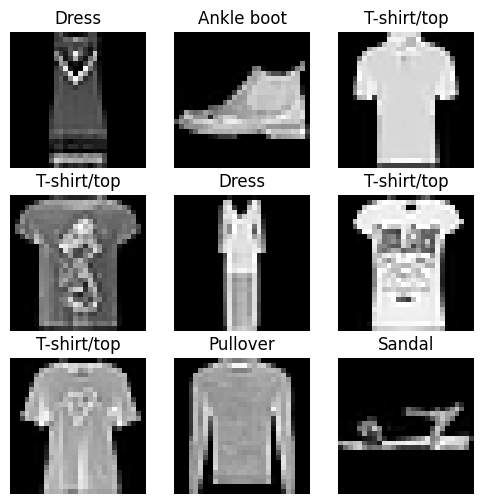

In [6]:
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(cols * rows):
    # 随机选择一个样本
    sample_idx = torch.randint(len(training_set), size=(1,)).item()
    # 通过索引直接访问数据集
    img, label = training_set[sample_idx]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(classes[label])
    plt.axis("off")  # 不显示x,y坐标轴上的刻度
    # img.shape: (1, 28, 28)
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Dataloader

有了 `Dataset` 后，其实我们已经可以通过下标下访问数据集中的每个样本了，但实际我们在做深度学习时，我们可能还有下面的需求：

- 希望按一个 minbatch 来读取数据
- 在每个 epoch 对整个数据集进行一次 shuffle 读取
- 可以使用多线程来加速读取与预处理数据

`Dataloader`就可以帮助dataset我们做这样的事情

Dataloader 负责加载数据，同时支持 map-style dataset 和 iterable-style dataset，支持单进程/多进程。同时还可以设置 loading order、batch size、pined memory等。

```python
Dataloader(dataset, batch_size, shuffle, num_worker,collate_fn,drop_last) -> Dataloader
```
我们通过传入 dataset 和一些参数返回一个 `Dataloader`,它是一个可迭代的对象

In [7]:
training_dataloader = torch.utils.data.DataLoader(
    training_set, batch_size=4, shuffle=True, num_workers=2
)

In [8]:
batch_samples, labels = next(iter(training_dataloader))
print(f"batch samples shape: {batch_samples.shape}")
print(labels)  # labels.shape: (batch_size,)

batch samples shape: torch.Size([4, 1, 28, 28])
tensor([7, 1, 8, 3])


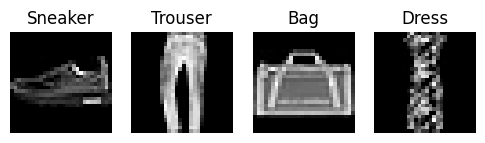

In [9]:
figure = plt.figure(figsize=(6, 6))
cols, rows = 4, 1
for i in range(cols * rows):
    img = batch_samples[i]
    label = labels[i].item()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## DataLoader的背后原理


<div class="wy-nav-content-img">
    <img src="assets/DataLoading_pipeliine.drawio.svg" width="600px" alt="DataLoader 读取数据的过程">
    <p>图1: DataLoader 读取数据的过程</p>
</div>

`DataLoader`是一个可迭代对象，所以它的核心功能就是内部的`__iter__`方法，实现了如何返回 `Dataset` 中的一个样本。

所以它先要获取一个或一批索引（dataset的key），它是由创建 `Dataloader` 时的 `Sampler` 提供的，`Sampler` 也是一个可迭代法对象，返回 `key` 值。

然后就是根据 `index` 来到`Dataset`里取数据，但是因为dataset有两类：`map-style` 和 `iterable-style`，所以直接用 `index` 不容易同时操作这两种对象。

Pytorch 又在访问两种 style dataset 之上，抽象了一个`dataset_fetcher`抽象类，它实现了一个`fetch`接口。对应的子类有：`_IterableDatasetFetcher`和`_MapDatasetFetcher`。

## Sampler

Sampler负责提供一种遍历数据集所有元素索引的方式：比如随机，顺序，按某种分布生成等。

Sampler 的所有子类都要实现`__iter__`用来提供遍历 `dataset` 索引的方式。我们获得不同的索引遍历，就是以不同的方式遍历 `dataset` ，这就是 Sampler 的目的。

Sampler每迭代一次，返回的都是 `Dataset` 的 key。

Pytorch为我们提供了几种现成的Sampler子类：

- SequentialSampler
- RandomSampler
- SubsetRandomSampler
- WeightedRandomSampler
- BatchSampler
- DistributedSampler

Sampler 的难点在于，在多进程的情况下，每个 worker 要根据 worker id 返回其对应的索引。 每个 worker 会根据自己的 `rank_id` 来获取当属于自己的那部分的 `indices`，然后就是这部分`indices`上进行迭代。

```python
def __iter__(self):
    if self.shuffle:
        # deterministically shuffle based on epoch and seed
        g = torch.Generator()
        g.manual_seed(self.seed + self.epoch)
        indices = torch.randperm(len(self.dataset), generator=g).tolist()  # type: ignore[arg-type]
    else:
        indices = list(range(len(self.dataset)))  # type: ignore[arg-type]

    if not self.drop_last:
        # add extra samples to make it evenly divisible
        padding_size = self.total_size - len(indices)
        if padding_size <= len(indices):
            indices += indices[:padding_size]
        else:
            indices += (indices * math.ceil(padding_size / len(indices)))[:padding_size]
    else:
        # remove tail of data to make it evenly divisible.
        indices = indices[: self.total_size]
    assert len(indices) == self.total_size

    # subsample
    indices = indices[self.rank : self.total_size : self.num_replicas]
    assert len(indices) == self.num_samples

    return iter(indices)
```

## 实现自定义的图片分类测试集

### 数据集介绍

https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

数据集是一个关于花的分类的数据集，它一共有5类，分别是:

|名称|描述|样本数量|
|:----:|:----:|:----:|
|daisy|雏菊|633|
|dandelion|蒲公英|898|
|roses|玫瑰|641|
|sunflowers|向日葵|699|
|tulips|郁金香|799|

数据集放在data/flower_photos目录下，每一类花就是一个文件夹，文件夹的名字是花的种类。

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

data_root = "../data/flowers"
flower_kinds = [
    kind
    for kind in os.listdir(data_root)
    if os.path.isdir(os.path.join(data_root, kind))
]
flower_kinds.sort()
kind_indices = {kind: i for i, kind in enumerate(flower_kinds)}
print(kind_indices)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


### 读取所有图片路径，并划分训练集与验证集

In [11]:
validation_rate = 0.2
training_images = []
training_labels = []
validation_images = []
validation_labels = []
kind_total = []
support_images = [".jpg", ".jpeg", ".png", ".bmp"]
for flower, label in kind_indices.items():
    flower_folder = os.path.join(data_root, flower)
    images = [
        os.path.join(flower_folder, image)
        for image in os.listdir(flower_folder)
        if os.path.isfile(os.path.join(flower_folder, image))
        and os.path.splitext(image)[-1] in support_images
    ]
    num_samples = len(images)
    kind_total.append(num_samples)
    num_train = int(num_samples * (1 - validation_rate))
    sampling_index = np.arange(num_samples)
    np.random.shuffle(sampling_index)
    training_images += [images[i] for i in sampling_index[:num_train]]
    training_labels += (np.ones(num_train, dtype="int64") * label).tolist()
    validation_images += [images[i] for i in sampling_index[num_train:]]
    validation_labels += (
        np.ones(num_samples - num_train, dtype="int64") * label
    ).tolist()

统计每个类别样本的数量

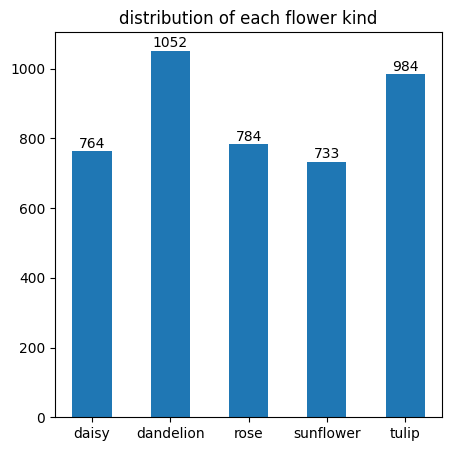

In [12]:
plt.figure(figsize=(5, 5))
plt.title("distribution of each flower kind")
plt.bar(range(len(kind_total)), kind_total, width=0.5, tick_label=flower_kinds)
for i, v in enumerate(kind_total):
    plt.text(x=i, y=v + 10, s=str(v), ha="center")

### 创建自定义数据集FlowerDataset

In [13]:
from torch.utils.data import Dataset
from PIL import Image


class FlowerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.images[index])
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(np.array(image)) / 255.0
        return image, torch.tensor(self.labels[index], dtype=torch.int64)

    def __len__(self):
        return len(self.images)

    # 由于每张图片的大小不同，所以没办法直接使用default_collate_fn（会调用stack）
    @staticmethod
    def collate_fn(batch):
        # zip([(a1, b1), (a2, b2), (a3, b3), ... (an, bn)]) = [(a1,a2,a3,...an), (b1,b2,b3,...,bn)]
        images, labels = tuple(zip(*batch))
        # 返回的images和labels都是一个tuple的形式
        return torch.stack(images, dim=0), torch.stack(labels, dim=0)

In [14]:
training_data = FlowerDataset(training_images, training_labels)

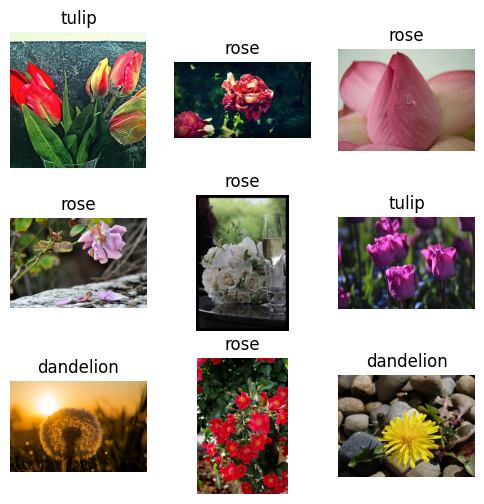

In [15]:
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(cols * rows):
    # 随机选择一个样本
    sample_idx = torch.randint(len(training_images), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(flower_kinds[int(label.item())])
    plt.axis("off")  # 不显示x,y坐标轴上的刻度
    plt.imshow(img.numpy())
plt.show()

In [16]:
import torchvision.transforms as trans

transform = trans.Compose(
    [
        trans.RandomResizedCrop((224, 224)),
        trans.ToTensor(),  # PIL image (HWC,0-255) -> Tensor(CHW, 0-1)
    ]
)

training_data = FlowerDataset(training_images, training_labels, transform)

training_dataloader = torch.utils.data.DataLoader(
    training_data, batch_size=4, shuffle=True, collate_fn=training_data.collate_fn
)

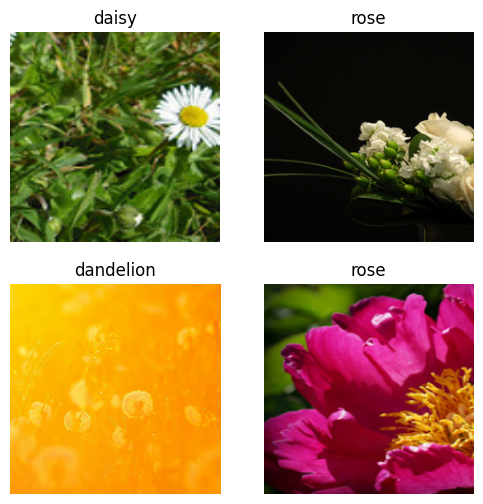

In [17]:
batch_samples, labels = next(iter(training_dataloader))
figure = plt.figure(figsize=(6, 6))
cols, rows = 2, 2
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i + 1)
    plt.title(flower_kinds[int(labels[i].item())])
    plt.axis("off")  # 不显示x,y坐标轴上的刻度
    plt.imshow(batch_samples[i].numpy().transpose((1, 2, 0)))
plt.show()

### 带 Transform 的 Dataset

In [18]:
import torchvision.transforms as T

In [19]:
transform = T.Compose(
    [
        T.RandomResizedCrop((224, 224)),
        T.ToTensor(),  # PIL image (HWC,0-255) -> Tensor(CHW, 0-1)
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [20]:
img = Image.open(training_images[0])
img = transform(img)
print(f"trasnformed image: {img.shape}")

trasnformed image: torch.Size([3, 224, 224])


In [21]:
training_data_with_trasform = FlowerDataset(training_images, training_labels, transform)

In [22]:
first_sample, label = training_data_with_trasform[0]
print(f"tensor shape: {first_sample.shape}, lable = {label}")

tensor shape: torch.Size([3, 224, 224]), lable = 0


In [23]:
# 由于dataset经过transform后，所有图片都是一样的大小，这时候，我们可以不用再提供collect_fn
training_dataloader = torch.utils.data.DataLoader(
    training_data_with_trasform, batch_size=4, shuffle=True
)
batch_samples, labels = next(iter(training_dataloader))
print(f"batch_samples.type: {type(batch_samples)}")

batch_samples.type: <class 'torch.Tensor'>


## 使用 ImageFolder

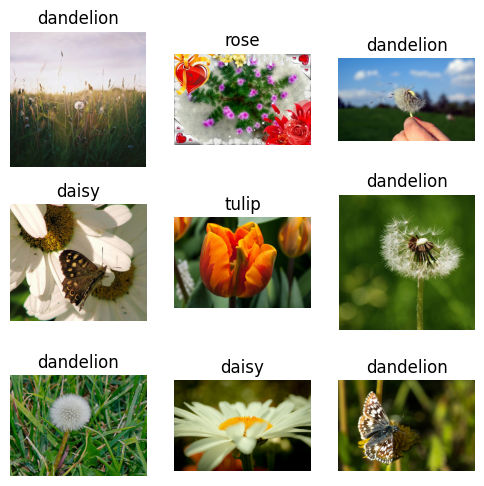

In [24]:
import torchvision.datasets

flower_dataset = torchvision.datasets.ImageFolder("../data/flowers/")

figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(cols * rows):
    # 随机选择一个样本
    sample_idx = torch.randint(len(training_images), size=(1,)).item()
    # img (PIL image), label (int)
    img, label = flower_dataset[sample_idx]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(flower_kinds[label])
    plt.axis("off")  # 不显示x,y坐标轴上的刻度
    plt.imshow(img)
plt.show()

## 带权重的样本采样器

当我们的数据集存在类别不均衡的问题时，我们可以采用带权重的 Sampler 来对数量较少的类别进行重复采样。另外，如果某些样本对于模型训练更为重要，可以为这些样本分配较高的权重，从而使模型更频繁地接触这些重要样本。比如在自然语言处理中，对于包含关键语义信息的句子给予更高的权重，以加速模型对关键信息的学习。

`WeightedRandomSampler`的要求传入一个`weights`参数，这是一个包含每个样本权重的张量。权重的长度应该与数据集的长度相同。例如，如果有一个包含 100 个样本的数据集，weights 张量也应该有 100 个元素。每个元素的值代表了对应样本被选中的概率（相对权重）。

In [25]:
import torchvision.datasets
import os

transform = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
    ]
)

data_root = "../data/flowers/"
flower_dataset = torchvision.datasets.ImageFolder(data_root, transform=transform)

subdirectories = flower_dataset.classes
class_weights = []
for subdir in subdirectories:
    files = os.listdir(os.path.join(data_root, subdir))
    class_weights.append(1 / len(files))

sample_weights = [0] * len(flower_dataset)

# 每个样本采样的权重为 1 / sampels，样本数量越少，则权重越大
for idx, (data, label) in enumerate(flower_dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = torch.utils.data.WeightedRandomSampler(
    sample_weights, num_samples=len(sample_weights), replacement=True
)
loader = torch.utils.data.DataLoader(flower_dataset, batch_size=8, sampler=sampler)

对整个数据集采用5次，然后统计的样本中每一个类别采样到的数量

In [26]:
num_retrivevers = [0] * len(flower_dataset.classes)

for epoch in range(5):
    for data, labels in loader:
        for id in range(len(num_retrivevers)):
            num_retrivevers[id] += torch.sum(labels == id).item()

print(num_retrivevers)

[4406, 4242, 4358, 4233, 4346]
